# Defining AOIs across reference images

Sometimes, we might be interested in AOIs that are spatially far apart from each other, eventually far enough that we cannot make one reference image that includes them all.

In this case, we can take one reference image for each AOI and analyse gaze data on and between these.

This notebook will show you how to 

- visualize multiple reference images next to each other
- load data from multiple reference image enrichments into one datafile

## Loading data from multiple folders

Once you've created multiple reference image mapper enrichments and downloaded them, we recommend putting all relevant enrichments into one folder. We named this folder "reference_image_enrichments"

Here, we used the Reference Image Mapper Enrichements "Gary_Cain", "Adel Dauood 2", "Christopher Blanc 2", "Adel Dauood 3", "Ingerlise Vikne", and "Gunlief Grube", all in the "walking" condition. You can download all these enrichments from our Demo Workspace.

To load the files recursively, we will first define some helper functions.

In [1]:
import os
import numpy as np
import pandas as pd

#ACTION NEEDED: Define the folder with our data
path_to_folders = './reference_image_enrichments/'

def get_file_list(file_name, directory = path_to_folders):
    """
    returns a list of paths to all files of a given name in subfolders of the given directory
    """
    all_aoi_recordings = os.listdir(directory)
    return [f"{directory}{aoi}/{file_name}" for aoi in all_aoi_recordings]

# define a function that extracts the image name from the path
extract_name = lambda name: name.split('MAPPER_')[1].split('_csv')[0]

def load_csv_files(file_name):  
    """
    recursively loads csv files and concatenates them in a long data frame
    """
    file_list = get_file_list(file_name)
    data = pd.DataFrame()
    
    for file_id, file in enumerate(file_list):
        
        df = pd.read_csv(file)
        df['AOI'] = file_id
        df['AOI_name'] = extract_name(file)
        
        data = pd.concat([data,df], ignore_index = True)
        
    return data

## Load and display an array of reference images

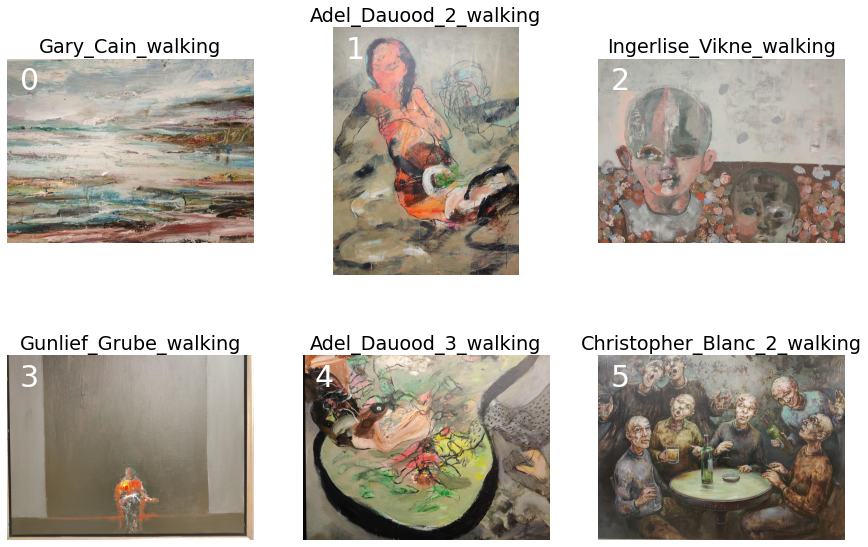

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams.update({'font.size': 16})

# Load images
images = get_file_list('reference_image.jpeg')

# Initialize list of AOI names
aoi_names = []

# create a plot for the images
fig_reference, ax_reference = plt.subplots(int(np.ceil(len(images)/3)),3, figsize = (15, 10))

def show_all_ref_images(images, axes):
    for ax, im, idx in zip(axes.flatten(), images, range(len(images))):
        reference_image = Image.open(im)
        ax.imshow(np.asarray(reference_image))
        name = extract_name(im)
        aoi_names.append(name)
        ax.set_title(name)
        ax.text(200, 500, idx, color='white', fontsize=30)
        ax.set_axis_off()
        
        
show_all_ref_images(images, ax_reference)
fig_reference.savefig('./figures/reference_image_distributed.png');

Each reference image contains only one painting, and hence, only one region of interest.

## Filter all fixations that were on the reference image

In [3]:
# Loading fixation data
fixations = load_csv_files('fixations.csv')
# defining a list of recording id names
recordings = np.unique(fixations['recording id'])

In [4]:
fixations = fixations[fixations['fixation detected in reference image']]

## Overlay the gaze position on top of the reference images

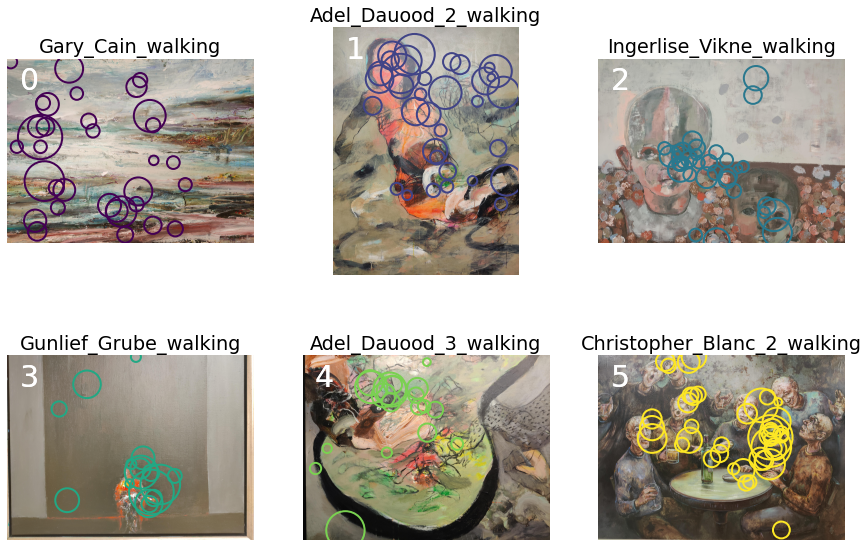

In [5]:
import matplotlib
aoi_colors = matplotlib.cm.get_cmap('viridis')
n_colorsteps = len(images) - 1

# take one example recording for the visualization
example_recording = recordings[0]
example_fixations = fixations[fixations['recording id'] == example_recording]

# plot the reference images in order
fig_fixations, axs_fixations = plt.subplots(int(np.ceil(len(images)/3)),3, figsize = (15, 10))
show_all_ref_images(images, axs_fixations)

# plot fixations on top of the reference images
for ax, aoi in zip(axs_fixations.flatten(), images):
    aoi_fixations = example_fixations[example_fixations['AOI_name'] == extract_name(aoi)]
    colors = [aoi_colors(x/n_colorsteps) for x in aoi_fixations['AOI']]
    ax.text(200, 500, np.unique(aoi_fixations['AOI'])[0], color='white', fontsize=30)
    
    ax.scatter(aoi_fixations['fixation x [px]'],
               aoi_fixations['fixation y [px]'],
               edgecolors = colors, 
               facecolors = 'none',
               linewidth = 2, 
               s = aoi_fixations['duration [ms]'])
    ax.set_axis_off();
    
fig_fixations.savefig('./figures/fixations_reference_image_distributed.png');

In [6]:
fixations.to_csv('fixations_with_aois_distributed.csv')